In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
claims = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/claims_byYear2.csv')
members = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_members2.csv')
drugs = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_drugcount.csv')
labs = pd.read_csv('C:/Users/Nguyen/Documents/Python Scripts/new_labcount.csv')
DY2 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y2.csv')
DY3 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y3.csv')
# Primary_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupPrimaryConditionGroup.csv')
# Procedure_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupProcedureGroup.csv')

In [4]:
#Xem xét các bảng drugs và labs
drugs.shape

(141571, 7)

In [5]:
labs.shape

(154934, 7)

In [6]:
# Merge 2 bảng drugs và labs
drugs_labs = pd.DataFrame()
drugs_labs = pd.merge(drugs,labs, on = ['MemberID','Year'], how = 'outer')
drugs_labs.head()

MemberID Year  Drug_total  Drug_count  DSFS_drugcount  DSFS_drugmax  \
0       210   Y1       5.000       3.000           3.000         5.000   
1       210   Y3       5.000       4.000           4.000         9.000   
2      3197   Y1       5.000       4.000           4.000        12.000   
3      3197   Y2       3.000       2.000           2.000         2.000   
4      3197   Y3       6.000       5.000           5.000        12.000   

   DSFS_drugmin  Lab_total  Lab_count  DSFS_labcount  DSFS_labmax  DSFS_labmin  
0         1.000      2.000      1.000          1.000        2.000        2.000  
1         6.000      1.000      1.000          1.000        3.000        3.000  
2         2.000        nan        nan            nan          nan          nan  
3         1.000      2.000      1.000          1.000        2.000        2.000  
4         0.000        nan        nan            nan          nan          nan

In [7]:
# 2 cột có ý nghĩa tương đương với DSFS_count: số lần đi khám bệnh, nên drop
drugs_labs.drop(['Drug_count', 'Lab_count'], axis='columns', inplace=True)

In [8]:
drugs_labs.head(20)

MemberID Year  Drug_total  DSFS_drugcount  DSFS_drugmax  DSFS_drugmin  \
0        210   Y1       5.000           3.000         5.000         1.000   
1        210   Y3       5.000           4.000         9.000         6.000   
2       3197   Y1       5.000           4.000        12.000         2.000   
3       3197   Y2       3.000           2.000         2.000         1.000   
4       3197   Y3       6.000           5.000        12.000         0.000   
5       3713   Y2      17.000           4.000         4.000         1.000   
6       3741   Y2      35.000          11.000        11.000         0.000   
7       3889   Y1      30.000          10.000        11.000         0.000   
8       4048   Y3       1.000           1.000         2.000         2.000   
9       4187   Y1      61.000          10.000         9.000         0.000   
10      5187   Y3      10.000           6.000         8.000         1.000   
11      9063   Y1       2.000           2.000         2.000         1.000   
12     10242   Y2       3.000           3.000         6.000         4.000   
13     14033   Y2       3.000           2.000         5.000         4.000   
14     14033   Y3       2.000           1.000         1.000         1.000   
15     14661   Y1       1.000           1.000         1.000         1.000   
16     14661   Y3       2.000           2.000         8.000         1.000   
17     14778   Y1       6.000           5.000         5.000         1.000   
18     14778   Y2      13.000          11.000        11.000         0.000   
19     14778   Y3       8.000           6.000         6.000         1.000   

    Lab_total  DSFS_labcount  DSFS_labmax  DSFS_labmin  
0       2.000          1.000        2.000        2.000  
1       1.000          1.000        3.000        3.000  
2         nan            nan          nan          nan  
3       2.000          1.000        2.000        2.000  
4         nan            nan          nan          nan  
5       9.000          2.000        9.000        2.000  
6      11.000          5.000        8.000        1.000  
7      10.000          1.000        1.000        1.000  
8      16.000          2.000        2.000        1.000  
9         nan            nan          nan          nan  
10      1.000          1.000        3.000        3.000  
11        nan            nan          nan          nan  
12      7.000          2.000        2.000        1.000  
13      1.000          1.000        5.000        5.000  
14      2.000          1.000        1.000        1.000  
15      2.000          1.000        1.000        1.000  
16        nan            nan          nan          nan  
17      2.000          1.000        1.000        1.000  
18      1.000          1.000        7.000        7.000  
19      8.000          3.000        4.000        1.000

In [10]:
#Kiểm tra tính null của các cột trong bảng drugs_labs
total_drugslabs = drugs_labs.isnull().sum().sort_values(ascending=False)
percent_drugslabs = (drugs_labs.isnull().sum()/drugs_labs.isnull().count()).sort_values(ascending=False)
missing_data_dl = pd.concat([total_drugslabs, percent_drugslabs], axis=1, keys=['Total', 'Percent'])
missing_data_dl.head()

Total  Percent
DSFS_drugmin    45231    0.242
DSFS_drugmax    45231    0.242
DSFS_drugcount  45231    0.242
Drug_total      45231    0.242
DSFS_labmin     31868    0.171

In [11]:
drugs_labs.shape

(186802, 10)

In [9]:
# Merge bảng drugs, labs, claims theo MemberID và year
new_drugs_labs_CBY = pd.merge(drugs_labs,claims, on = ['MemberID','Year'], how='outer')
new_drugs_labs_CBY.head()

MemberID Year  Drug_total  DSFS_drugcount  DSFS_drugmax  DSFS_drugmin  \
0       210   Y1       5.000           3.000         5.000         1.000   
1       210   Y3       5.000           4.000         9.000         6.000   
2      3197   Y1       5.000           4.000        12.000         2.000   
3      3197   Y2       3.000           2.000         2.000         1.000   
4      3197   Y3       6.000           5.000        12.000         0.000   

   Lab_total  DSFS_labcount  DSFS_labmax  DSFS_labmin  Provider_Total  \
0      2.000          1.000        2.000        2.000               8   
1      1.000          1.000        3.000        3.000               4   
2        nan            nan          nan          nan               5   
3      2.000          1.000        2.000        2.000               5   
4        nan            nan          nan          nan              11   

   Provider_Distinct  Vendor_Distinct  PCP_Distinct  Specialty_Distinct  \
0                  4                4             2                   3   
1                  2                2             1                   2   
2                  3                3             1                   2   
3                  4                3             1                   4   
4                  3                1             1                   2   

   PlaceSvc_Distinct  PayDelay_sum  PayDelay_max  PayDelay_min  PCG_Distinct  \
0                  3           720           162            22             4   
1                  2           143            44            23             2   
2                  2           492           162            36             2   
3                  2           148            34            26             2   
4                  1           379           119            21             3   

   ProG_Distinct  DSFS_Count  DSFS_max  DSFS_min  CI_sum  CI_max  CI_min  \
0              5           8     7.000     0.000       0       0       0   
1              2           4     7.000     1.000       0       0       0   
2              2           5    12.000     1.000       0       0       0   
3              4           5     2.000     1.000       0       0       0   
4              2          11    11.000     1.000      22       2       2   

   LOS_sum  LOS_max  LOS_min  sp1_Int  sp2_Lab  sp3_Prac  sp4_Sur  sp5_DiIma  \
0    2.000    2.000    2.000       22        7         0        5          1   
1    0.000      nan      nan        8       15         0        2          3   
2    0.000      nan      nan       13        8         8       12          1   
3    0.000      nan      nan        0        0         0        0          0   
4    0.000      nan      nan        0        3         1        0          1   

   sp6_Emer  sp7_Other  sp8_Pedia  sp9_Rehab  sp10_Obs  sp11_Anes  sp12_Path  \
0         0          6          0          0         0          2          1   
1         0          0          0          0         2          0          0   
2         0          1          0          0         0          0          0   
3         0          0          6          0         0          0          0   
4         1          0          0          6         0          0          0   

   sp13_null  pgc1_MSC2a3  pgc2_METAB3  pgc3_ARTHSPIN  pgc4_NEUMENT  \
0          0            7            6              0             6   
1          0            3           13              5             0   
2          0           17            2              2             0   
3          0            1            0              0             5   
4          0            2            0              2             0   

   pgc5_RESPR4  pgc6_MISCHRT  pgc7_SKNAUT  pgc8_GIBLEED  pgc9_INFEC4  \
0            0             5            0             2            0   
1            5             0            0             0            1   
2            2             1            0             0            0   
3            0             0            0

In [13]:
new_drugs_labs_CBY.shape

(218415, 116)

In [10]:
# Merge bảng drugs, labs, claims và Members theo MemberID và year
new_claims = pd.merge(new_drugs_labs_CBY,members, on = 'MemberID')
new_claims.head()

MemberID Year  Drug_total  DSFS_drugcount  DSFS_drugmax  DSFS_drugmin  \
0       210   Y1       5.000           3.000         5.000         1.000   
1       210   Y3       5.000           4.000         9.000         6.000   
2       210   Y2         nan             nan           nan           nan   
3      3197   Y1       5.000           4.000        12.000         2.000   
4      3197   Y2       3.000           2.000         2.000         1.000   

   Lab_total  DSFS_labcount  DSFS_labmax  DSFS_labmin  Provider_Total  \
0      2.000          1.000        2.000        2.000               8   
1      1.000          1.000        3.000        3.000               4   
2      1.000          1.000        1.000        1.000               6   
3        nan            nan          nan          nan               5   
4      2.000          1.000        2.000        2.000               5   

   Provider_Distinct  Vendor_Distinct  PCP_Distinct  Specialty_Distinct  \
0                  4                4             2                   3   
1                  2                2             1                   2   
2                  3                3             1                   3   
3                  3                3             1                   2   
4                  4                3             1                   4   

   PlaceSvc_Distinct  PayDelay_sum  PayDelay_max  PayDelay_min  PCG_Distinct  \
0                  3           720           162            22             4   
1                  2           143            44            23             2   
2                  2           308           128            31             2   
3                  2           492           162            36             2   
4                  2           148            34            26             2   

   ProG_Distinct  DSFS_Count  DSFS_max  DSFS_min  CI_sum  CI_max  CI_min  \
0              5           8     7.000     0.000       0       0       0   
1              2           4     7.000     1.000       0       0       0   
2              3           6     7.000     0.000       0       0       0   
3              2           5    12.000     1.000       0       0       0   
4              4           5     2.000     1.000       0       0       0   

   LOS_sum  LOS_max  LOS_min  sp1_Int  sp2_Lab  sp3_Prac  sp4_Sur  sp5_DiIma  \
0    2.000    2.000    2.000       22        7         0        5          1   
1    0.000      nan      nan        8       15         0        2          3   
2    0.000      nan      nan        1        2         0        0          0   
3    0.000      nan      nan       13        8         8       12          1   
4    0.000      nan      nan        0        0         0        0          0   

   sp6_Emer  sp7_Other  sp8_Pedia  sp9_Rehab  sp10_Obs  sp11_Anes  sp12_Path  \
0         0          6          0          0         0          2          1   
1         0          0          0          0         2          0          0   
2         0          0          0          0         0          0          0   
3         0          1          0          0         0          0          0   
4         0          0          6          0         0          0          0   

   sp13_null  pgc1_MSC2a3  pgc2_METAB3  pgc3_ARTHSPIN  pgc4_NEUMENT  \
0          0            7            6              0             6   
1          0            3           13              5             0   
2          0            0            3              0             0   
3          0           17            2              2             0   
4          0            1            0              0             5   

   pgc5_RESPR4  pgc6_MISCHRT  pgc7_SKNAUT  pgc8_GIBLEED  pgc9_INFEC4  \
0            0             5            0             2            0   
1            5             0            0             0            1   
2            0             0            0             0            0   
3            2             1            0

In [15]:
#đếm null của bảng tổng hợp được
total = new_claims.isnull().sum().sort_values(ascending=False)
percent = (new_claims.isnull().sum()/new_claims.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
LOS_min         174113    0.797
LOS_max         174113    0.797
Drug_total       76844    0.352
DSFS_drugcount   76844    0.352
DSFS_drugmax     76844    0.352
DSFS_drugmin     76844    0.352
Lab_total        63481    0.291
DSFS_labcount    63481    0.291
DSFS_labmax      63481    0.291
DSFS_labmin      63481    0.291
DSFS_min            52    0.000
DSFS_max            52    0.000
pgc6_MISCHRT         0    0.000
pgc5_RESPR4          0    0.000
pgc4_NEUMENT         0    0.000
pgc3_ARTHSPIN        0    0.000
missing_sex          0    0.000
pgc2_METAB3          0    0.000
pgc1_MSC2a3          0    0.000
sp13_null            0    0.000

In [16]:
#fill các giá trị na = 0 trong bảng tổng hợp
new_claims.fillna(0,inplace=True)

In [17]:
new_claims.to_csv('new_claims.csv',index=False)

In [15]:
# Load hai bảng target của Y1 past year và Y2 curr year
Target_pastyear = pd.DataFrame()
Target_pastyear = DY2
Target_pastyear.describe()

MemberID  ClaimsTruncated  DaysInHospital
count    76038.000        76038.000       76038.000
mean  49947611.565            0.052           0.467
std   28901449.395            0.222           1.612
min        210.000            0.000           0.000
25%   24837194.750            0.000           0.000
50%   49907210.000            0.000           0.000
75%   75101120.750            0.000           0.000
max   99998627.000            1.000          15.000

In [16]:
Target_curryear = pd.DataFrame()
Target_curryear = DY3
Target_curryear.describe()

MemberID  ClaimsTruncated  DaysInHospital
count    71435.000        71435.000       71435.000
mean  49939856.726            0.057           0.438
std   28940770.025            0.231           1.532
min          4.000            0.000           0.000
25%   24778132.500            0.000           0.000
50%   49953793.000            0.000           0.000
75%   75219855.000            0.000           0.000
max   99998824.000            1.000          15.000

In [11]:
claims_pastyear = new_claims[new_claims.Year == 'Y1']
claims_pastyear.describe()

MemberID  Drug_total  DSFS_drugcount  DSFS_drugmax  DSFS_drugmin  \
count    76038.000   49838.000       49838.000     49838.000     49838.000   
mean  49947611.565      15.438           5.651         7.428         1.096   
std   28901449.395      16.659           3.810         3.812         1.629   
min        210.000       1.000           1.000         0.000         0.000   
25%   24837194.750       3.000           2.000         4.000         0.000   
50%   49907210.000       9.000           5.000         8.000         1.000   
75%   75101120.750      22.000           9.000        11.000         1.000   
max   99998627.000      84.000          12.000        12.000        12.000   

       Lab_total  DSFS_labcount  DSFS_labmax  DSFS_labmin  Provider_Total  \
count  53227.000      53227.000    53227.000    53227.000       76038.000   
mean       8.784          2.258        5.069        1.951          11.320   
std        7.183          1.781        3.608        2.158          10.480   
min        1.000          1.000        0.000        0.000           0.000   
25%        4.000          1.000        1.000        1.000           3.000   
50%        7.000          2.000        5.000        1.000           8.000   
75%       12.000          3.000        8.000        2.000          16.000   
max       89.000         12.000       12.000       12.000          43.000   

       Provider_Distinct  Vendor_Distinct  PCP_Distinct  Specialty_Distinct  \
count          76038.000        76038.000     76038.000           76038.000   
mean               4.404            3.706         1.022               3.183   
std                3.341            2.616         0.151               1.770   
min                0.000            0.000         0.000               0.000   
25%                2.000            2.000         1.000               2.000   
50%                3.000            3.000         1.000               3.000   
75%                6.000            5.000         1.000               4.000   
max               27.000           19.000         3.000              10.000   

       PlaceSvc_Distinct  PayDelay_sum  PayDelay_max  PayDelay_min  \
count          76038.000     76038.000     76038.000     76038.000   
mean               2.145       614.360       101.490        29.729   
std                1.021       631.763        50.450        23.731   
min                0.000         0.000         0.000         0.000   
25%                1.000       162.000        56.000        17.000   
50%                2.000       389.000        94.000        24.000   
75%                3.000       844.000       162.000        33.000   
max                8.000      6202.000       162.000       162.000   

       PCG_Distinct  ProG_Distinct  DSFS_Count  DSFS_max  DSFS_min    CI_sum  \
count     76038.000      76038.000   76038.000 76020.000 76020.000 76038.000   
mean          3.718          3.761      11.175     5.877     0.781    10.067   
std           2.467          1.929      10.329     3.898     0.422    20.372   
min           0.000          0.000       0.000     1.000     0.000     0.000   
25%           2.000          2.000       3.000     1.000     1.000     0.000   
50%           3.000          4.000       7.000     6.000     1.000     0.000   
75%           5.000          5.000      16.000     9.000     1.000    10.000   
max          17.000         12.000      43.000    12.000     7.000   202.000   

         CI_max    CI_min   LOS_sum   LOS_max   LOS_min   sp1_Int   sp2_Lab  \
count 76038.000 76038.000 76038.000 14405.000 14405.000 76038.000 76038.000   
mean      0.713     0.268     0.692     1.733     1.376     6.156     5.883   
std       1.115     0.684    11.654     3.786     2.303     6.554     6.988   
min       0.000     0.000     0.000     1.000     1.000     0.000     0.000   
25%       0.000     0.000     0.000     1.000     1.000     1.000     2.000   
50%       0.000     0.000     0.000     1.000     1.000     4.000     4.000

In [12]:
claims_curryear = new_claims[new_claims.Year == 'Y2']
claims_curryear.head()

MemberID Year  Drug_total  DSFS_drugcount  DSFS_drugmax  DSFS_drugmin  \
2        210   Y2         nan             nan           nan           nan   
4       3197   Y2       3.000           2.000         2.000         1.000   
6       3713   Y2      17.000           4.000         4.000         1.000   
7       3741   Y2      35.000          11.000        11.000         0.000   
12      5187   Y2         nan             nan           nan           nan   

    Lab_total  DSFS_labcount  DSFS_labmax  DSFS_labmin  Provider_Total  \
2       1.000          1.000        1.000        1.000               6   
4       2.000          1.000        2.000        2.000               5   
6       9.000          2.000        9.000        2.000              10   
7      11.000          5.000        8.000        1.000              20   
12        nan            nan          nan          nan               2   

    Provider_Distinct  Vendor_Distinct  PCP_Distinct  Specialty_Distinct  \
2                   3                3             1                   3   
4                   4                3             1                   4   
6                   5                5             2                   3   
7                   3                3             1                   3   
12                  1                1             1                   1   

    PlaceSvc_Distinct  PayDelay_sum  PayDelay_max  PayDelay_min  PCG_Distinct  \
2                   2           308           128            31             2   
4                   2           148            34            26             2   
6                   2           562           118            23             5   
7                   2           360            36             8             4   
12                  1            65            42            23             2   

    ProG_Distinct  DSFS_Count  DSFS_max  DSFS_min  CI_sum  CI_max  CI_min  \
2               3           6     7.000     0.000       0       0       0   
4               4           5     2.000     1.000       0       0       0   
6               3          10     9.000     1.000       0       0       0   
7               4          20     8.000     1.000       4       2       0   
12              1           2     1.000     1.000       0       0       0   

    LOS_sum  LOS_max  LOS_min  sp1_Int  sp2_Lab  sp3_Prac  sp4_Sur  sp5_DiIma  \
2     0.000      nan      nan        1        2         0        0          0   
4     0.000      nan      nan        0        0         0        0          0   
6     0.000      nan      nan        4        3         0        0          2   
7     0.000      nan      nan       19        6         4        3          6   
12    0.000      nan      nan        6        8         0        3          1   

    sp6_Emer  sp7_Other  sp8_Pedia  sp9_Rehab  sp10_Obs  sp11_Anes  sp12_Path  \
2          0          0          0          0         0          0          0   
4          0          0          6          0         0          0          0   
6          0          0          0          6         0          0          0   
7          1          0          0          2         0          0          3   
12         0          4          0          0         0          0          0   

    sp13_null  pgc1_MSC2a3  pgc2_METAB3  pgc3_ARTHSPIN  pgc4_NEUMENT  \
2           0            0            3              0             0   
4           0            1            0              0             5   
6           0            3            0              3             0   
7           0            3            1              9             1   
12          0            6            9              0             0   

    pgc5_RESPR4  pgc6_MISCHRT  pgc7_SKNAUT  pgc8_GIBLEED  pgc9_INFEC4  \
2             0             0            0             0            0   
4             0             0            0             0            0   
6             0             0            1             0       

In [21]:
claims_pastyear.shape

(76038, 129)

In [22]:
claims_curryear.shape

(71435, 129)

In [17]:
fclaims_pastyr = pd.merge (claims_pastyear,Target_pastyear, on = 'MemberID')

In [18]:
fclaims_curryr = pd.merge (claims_curryear,Target_curryear, on = 'MemberID')

In [19]:
fclaims_pastyr.rename(columns={'DaysInHospital': 'Target'}, inplace=True)
fclaims_curryr.rename(columns={'DaysInHospital': 'Target'}, inplace=True)

In [57]:
fclaims_pastyr.to_csv('fclaims_pastyr.csv',index=False)

In [58]:
fclaims_curryr.to_csv('fclaims_curryr.csv',index=False)

In [25]:
fclaims_pastyr.dtypes

MemberID                int64
Year                   object
Drug_total            float64
DSFS_drugcount        float64
DSFS_drugmax          float64
DSFS_drugmin          float64
Lab_total             float64
DSFS_labcount         float64
DSFS_labmax           float64
DSFS_labmin           float64
Provider_Total          int64
Provider_Distinct       int64
Vendor_Distinct         int64
PCP_Distinct            int64
Specialty_Distinct      int64
PlaceSvc_Distinct       int64
PayDelay_sum            int64
PayDelay_max            int64
PayDelay_min            int64
PCG_Distinct            int64
ProG_Distinct           int64
DSFS_Count              int64
DSFS_max              float64
DSFS_min              float64
CI_sum                  int64
CI_max                  int64
CI_min                  int64
LOS_sum               float64
LOS_max               float64
LOS_min               float64
sp1_Int                 int64
sp2_Lab                 int64
sp3_Prac                int64
sp4_Sur   

In [26]:
display(fclaims_pastyr.describe().transpose())

count         mean          std     min          25%  \
MemberID           76038.000 49947611.565 28901449.395 210.000 24837194.750   
Drug_total         76038.000       10.118       15.353   0.000        0.000   
DSFS_drugcount     76038.000        3.704        4.090   0.000        0.000   
DSFS_drugmax       76038.000        4.869        4.689   0.000        0.000   
DSFS_drugmin       76038.000        0.719        1.418   0.000        0.000   
Lab_total          76038.000        6.149        7.233   0.000        0.000   
DSFS_labcount      76038.000        1.580        1.814   0.000        0.000   
DSFS_labmax        76038.000        3.549        3.809   0.000        0.000   
DSFS_labmin        76038.000        1.366        2.014   0.000        0.000   
Provider_Total     76038.000       11.320       10.480   0.000        3.000   
Provider_Distinct  76038.000        4.404        3.341   0.000        2.000   
Vendor_Distinct    76038.000        3.706        2.616   0.000        2.000   
PCP_Distinct       76038.000        1.022        0.151   0.000        1.000   
Specialty_Distinct 76038.000        3.183        1.770   0.000        2.000   
PlaceSvc_Distinct  76038.000        2.145        1.021   0.000        1.000   
PayDelay_sum       76038.000      614.360      631.763   0.000      162.000   
PayDelay_max       76038.000      101.490       50.450   0.000       56.000   
PayDelay_min       76038.000       29.729       23.731   0.000       17.000   
PCG_Distinct       76038.000        3.718        2.467   0.000        2.000   
ProG_Distinct      76038.000        3.761        1.929   0.000        2.000   
DSFS_Count         76038.000       11.175       10.329   0.000        3.000   
DSFS_max           76038.000        5.876        3.899   0.000        1.000   
DSFS_min           76038.000        0.781        0.422   0.000        1.000   
CI_sum             76038.000       10.067       20.372   0.000        0.000   
CI_max             76038.000        0.713        1.115   0.000        0.000   
CI_min             76038.000        0.268        0.684   0.000        0.000   
LOS_sum            76038.000        0.692       11.654   0.000        0.000   
LOS_max            76038.000        0.328        1.783   0.000        0.000   
LOS_min            76038.000        0.261        1.138   0.000        0.000   
sp1_Int            76038.000        6.156        6.554   0.000        1.000   
sp2_Lab            76038.000        5.883        6.988   0.000        2.000   
sp3_Prac           76038.000        3.470        4.421   0.000        0.000   
sp4_Sur            76038.000        1.985        3.195   0.000        0.000   
sp5_DiIma          76038.000        1.854        2.179   0.000        0.000   
sp6_Emer           76038.000        0.927        1.798   0.000        0.000   
sp7_Other          76038.000        0.980        2.888   0.000        0.000   
sp8_Pedia          76038.000        0.350        1.831   0.000        0.000   
sp9_Rehab          76038.000        0.662        2.628   0.000        0.000   
sp10_Obs           76038.000        0.263        1.208   0.000        0.000   
sp11_Anes          76038.000        0.361        1.382   0.000        0.000   
sp12_Path          76038.000        0.141        0.518   0.000        0.000   
sp13_null          76038.000        0.074        0.506   0.000        0.000   
pgc1_MSC2a3        76038.000        4.097        5.678   0.000        1.000   
pgc2_METAB3        76038.000        2.691        4.278   0.000        0.000   
pgc3_ARTHSPIN      76038.000        2.738        5.103   0.000        0.000   
pgc4_NEUMENT       76038.000        1.411        2.867   0.000        0.000   
pgc5_RESPR4        76038.000        1.000        2.639   0.000        0.000   
pgc6_MISCHRT       76038.000        1.062        2.245   0.000        0.000   
pgc7_SKNAUT        76038.000        0.920        2.564   0.000        0.000   
pgc8_GIBLEED       76038.000        0.872        2.256   0.000        0.0

C:\Users\Nguyen\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Target_DIS_Pastyr')

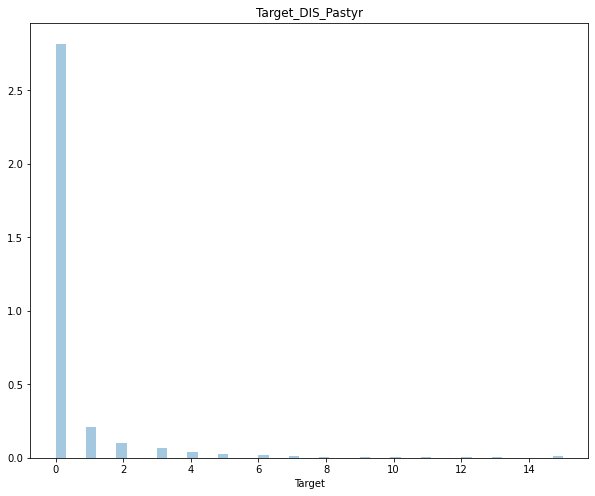

In [61]:
# Xem xét distribution của Target trong fclaims_pastyr. 
# Hầu hết đều tập trung ở mức 0 ngày và có một số lượng nhất định dưới 4 ngày
plt.figure(figsize = (10, 8))
sns.distplot(fclaims_pastyr['Target'])
plt. title ('Target_DIS_Pastyr')

In [28]:
fclaims_pastyr.groupby(['Target']).size()

Target
0     64269
1      4835
2      2366
3      1453
4       977
5       565
6       373
7       256
8       173
9       148
10      106
11       80
12       73
13       61
14       42
15      261
dtype: int64

In [29]:
# Đổi tên biến Provider_total thành Claims_Distinct
fclaims_pastyr.rename(columns = {'Provider_Total':'Claims_Distinct'}, inplace = True)
fclaims_pastyr.dtypes

MemberID                int64
Year                   object
Drug_total            float64
DSFS_drugcount        float64
DSFS_drugmax          float64
DSFS_drugmin          float64
Lab_total             float64
DSFS_labcount         float64
DSFS_labmax           float64
DSFS_labmin           float64
Claims_Distinct         int64
Provider_Distinct       int64
Vendor_Distinct         int64
PCP_Distinct            int64
Specialty_Distinct      int64
PlaceSvc_Distinct       int64
PayDelay_sum            int64
PayDelay_max            int64
PayDelay_min            int64
PCG_Distinct            int64
ProG_Distinct           int64
DSFS_Count              int64
DSFS_max              float64
DSFS_min              float64
CI_sum                  int64
CI_max                  int64
CI_min                  int64
LOS_sum               float64
LOS_max               float64
LOS_min               float64
sp1_Int                 int64
sp2_Lab                 int64
sp3_Prac                int64
sp4_Sur   

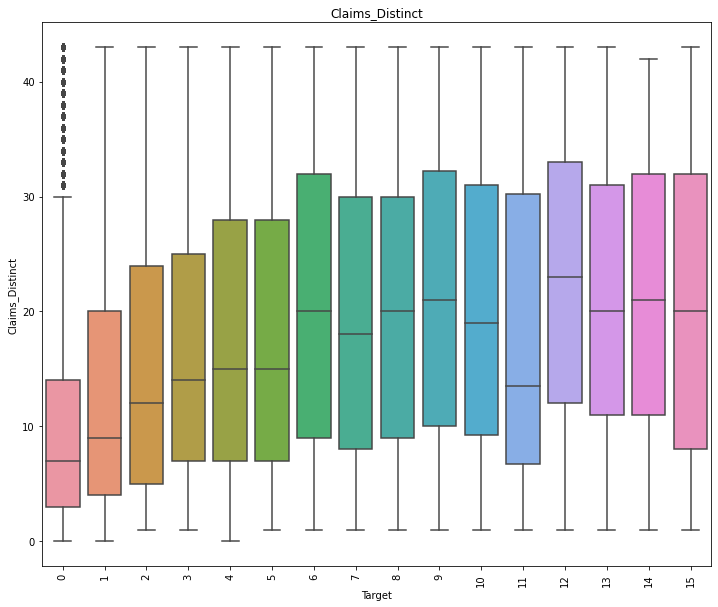

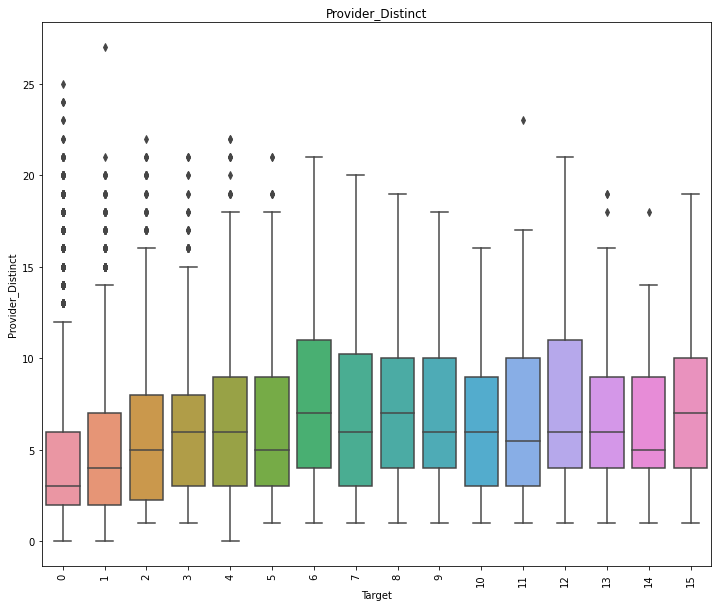

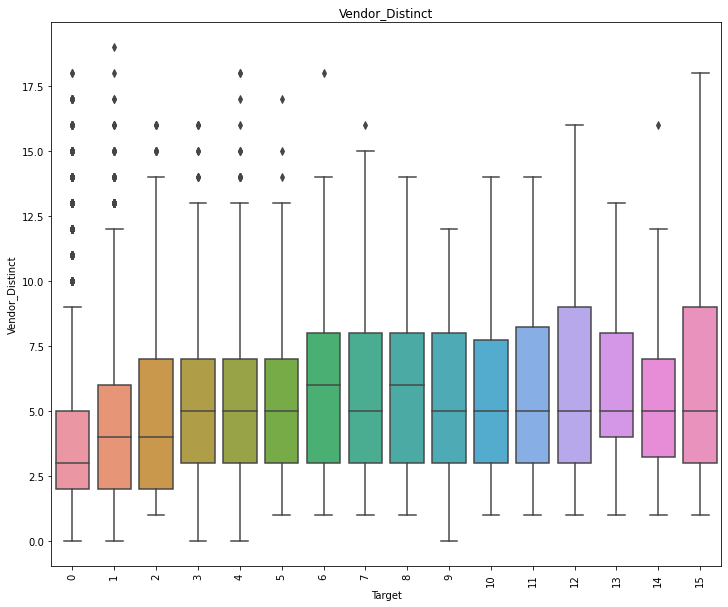

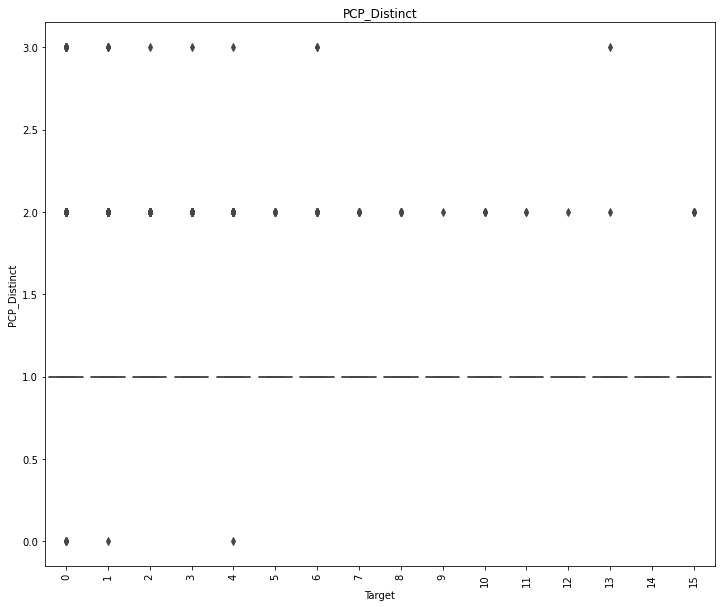

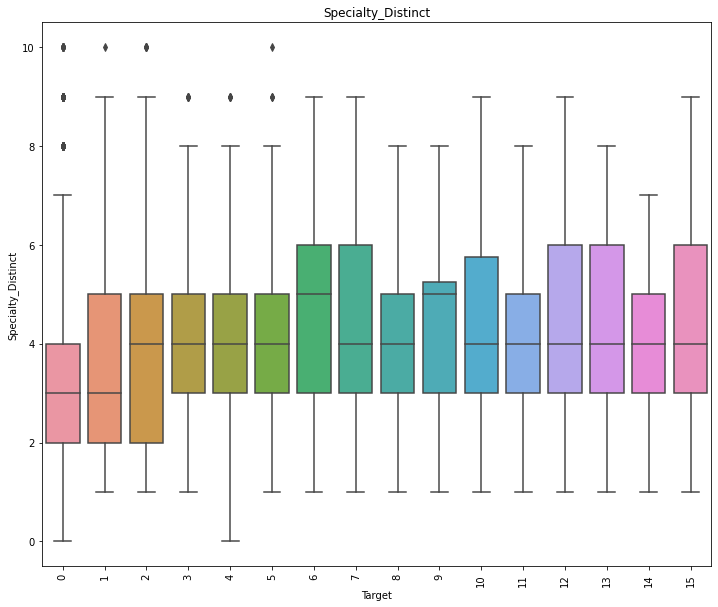

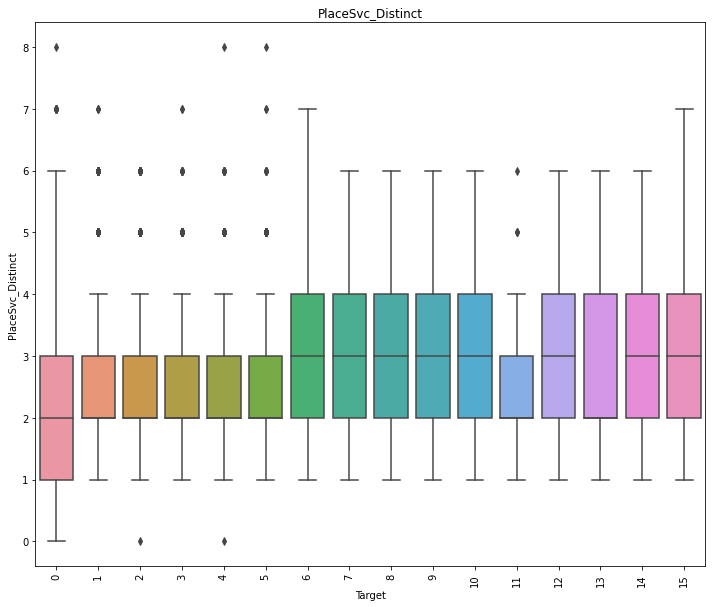

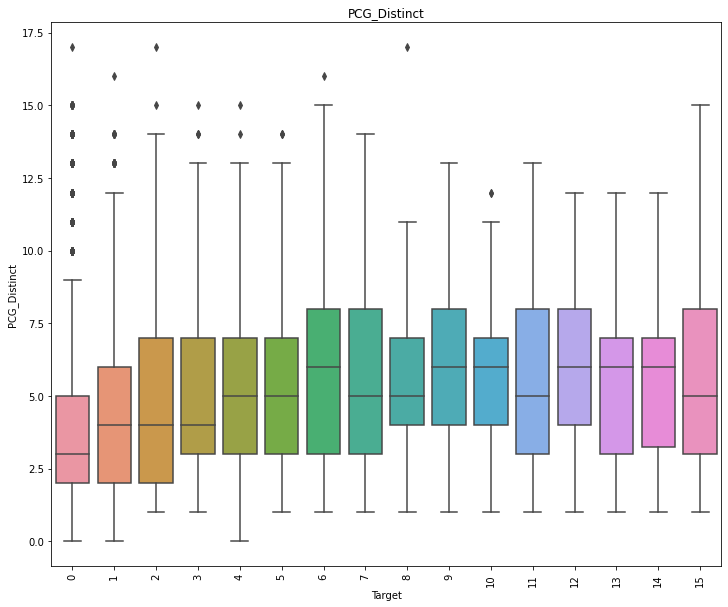

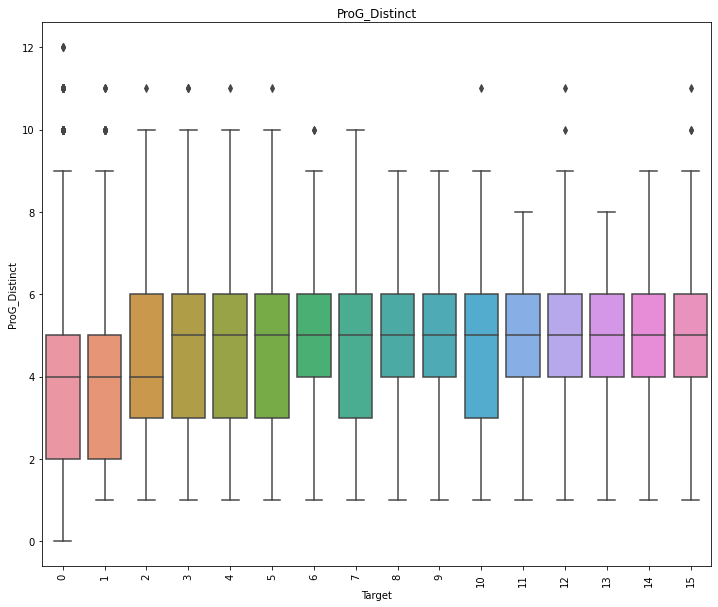

In [35]:
# Như ở file claims đầu tiên, kiểm tra các biến 'Đã từng' là categorical với biến target
#prior_cate = list(col for col in prior_cate.columns if '_Distinct' in col]
#print(prior_cate)

#Load hết tất cả các cột categorical chạy boxplot
for col in fclaims_pastyr.columns:
    if 'Distinct'in col:
        plt.figure(figsize = (12, 10))
        sns.boxplot(x='Target',y=col, data = fclaims_pastyr)
        plt.title(col)
        plt.xticks(rotation=90)
        plt.show
# Nhìn xu hướng chung, có 1 uptrend (theo median và min, max) của các 'prior_Categorical' variables với Target (Days in Hospital) trong vòng 6 ngày DIH đỗ lại
# Có nghĩa là DIH < 6 ngày, có thể visualize được tăng thêm đơn vị cho #Claims, #Provider, #Vendor, #Specialty, #Condition,... sẽ tăng số ngày nằm viện
#Sau đó thì Target có variance hơn
# Tuy nhiên, ở đây nên xét cho trường hợp distribution của Target hầu hết đang là 0-1 ngày (đã được check qua biến LOS của bảng claims)

In [30]:
fclaims_pastyr2 = pd.DataFrame()
fclaims_pastyr2 = fclaims_pastyr
fclaims_pastyr2.drop(['Year'], axis='columns', inplace=True)

In [41]:
fclaims_pastyr2.shape

(76038, 130)

In [45]:
#Câu hỏi đặt ra là, trong các biến như vậy thì biến nào quan trọng hơn trong việc dự đoán Days
#Sử dụng random forest classification kết hợp với feature_importances
#Vì bài này về bản chất cũng là phân loại dựa trên nhiều điều kiện khác nhau của các biến số

#Xác định X, Y của phân tích
#y là target (DIH)
#x là các cột còn lại, k tính Year và Target
y = fclaims_pastyr2.Target
X = fclaims_pastyr2.loc[:, fclaims_pastyr2.columns != 'Target']

#Xác định sử dụng model RandomForestClassifier
model = RandomForestClassifier(max_depth=5, random_state = 0)
#Fit in X, y vào model 
model.fit(X, y)

#Xem xét feature_importance
importances = model.feature_importances_
#Xếp thứ tự các feature (các cột) theo mức độ ảnh hưởng quan trọng lên target
indices = np.argsort(importances)[::-1]

# Tổng hợp feature_importance
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], fclaims_pastyr2.columns[indices[f]], importances[indices[f]]))

1. feature 127 missing_sex (0.097558)
2. feature 9 Provider_Total (0.085329)
3. feature 11 Vendor_Distinct (0.063994)
4. feature 18 PCG_Distinct (0.062642)
5. feature 23 CI_sum (0.055264)
6. feature 10 Provider_Distinct (0.054909)
7. feature 15 PayDelay_sum (0.047554)
8. feature 124 missing_age (0.045142)
9. feature 20 DSFS_Count (0.044560)
10. feature 128 ClaimsTruncated (0.040589)
11. feature 123 80.000 (0.040490)
12. feature 1 Drug_total (0.032341)
13. feature 26 LOS_sum (0.029341)
14. feature 24 CI_max (0.024572)
15. feature 27 LOS_max (0.022922)
16. feature 13 Specialty_Distinct (0.021801)
17. feature 14 PlaceSvc_Distinct (0.021736)
18. feature 2 DSFS_drugcount (0.016373)
19. feature 28 LOS_min (0.014679)
20. feature 5 Lab_total (0.014398)
21. feature 125 Sex_male (0.014396)
22. feature 19 ProG_Distinct (0.014202)
23. feature 3 DSFS_drugmax (0.011359)
24. feature 21 DSFS_max (0.009983)
25. feature 16 PayDelay_max (0.006868)
26. feature 6 DSFS_labcount (0.006375)
27. feature 126 Se

In [ ]:
# Có 1 số feature có ảnh hưởng lớn hơn các feature khác trong số ngày nằm viện:
# Provider_Total (CLaims_distinct): Số lượng claim của KH trong năm
# Vendor_Distinct: Tổng số lượng vendor (unique) của KH trong năm
# PCG_Distinct: Số bệnh (condition) unique của KH trong năm
# CI_sum: Tổng số CI của bệnh nhân trong năm. CI càng cao thì nguy cơ tử vong càng cao, tuy nhiên xem xét đến mối quan hệ CI và LOS ở bảng claims đầu tiên
# Provider_Distinct: số nhà cung cấp unique của KH trong năm
# PayDelay_sum: Tổng số ngày chờ chi trả, của KH trong năm. PayDelay có mối quan hệ 'Fairly correlation với PCG Distinct/DSFS count'
# missing_sex/missing_age: Sự thiếu thông tin lúc KH claim có thể liên quan đến số ngày nằm viện. 
# Có thể tạm giải thích bằng việc không khai báo đủ thông tin cá nhân rơi vào những bệnh nhân có rủi ro nằm viện lâu (có thể có chủ đích giấu thông tin hoặc không)

# Có 2 biến tổng từ những value của các categorical variable ban đàu:
# 80 tuổi và giới tính Nam: Hai đối tượng này có khả năng nằm viện lâu hơn so với những yếu tố khác 

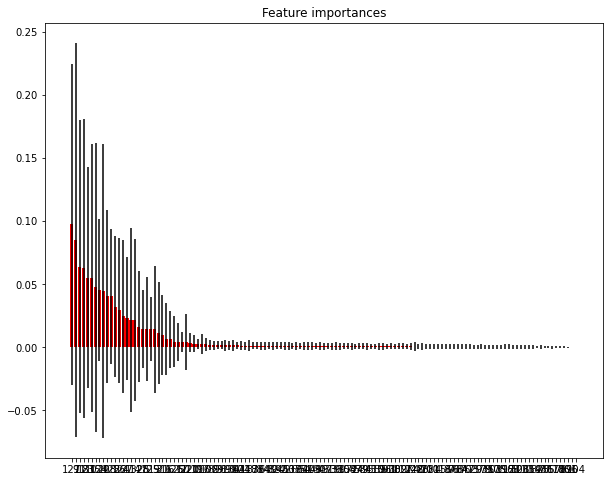

In [58]:
#tính standard deviation (y-error)
std = np.std([x.feature_importances_ for x in model.estimators_],axis = 0)

# Vẽ chart bar để visualize ferature_importance
plt.figure(figsize = (10, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices])
plt.xticks(range(X.shape[1]),indices)
plt.show()

In [59]:
fclaims_pastyr.dtypes

MemberID                int64
Drug_total            float64
DSFS_drugcount        float64
DSFS_drugmax          float64
DSFS_drugmin          float64
Lab_total             float64
DSFS_labcount         float64
DSFS_labmax           float64
DSFS_labmin           float64
Provider_Total          int64
Provider_Distinct       int64
Vendor_Distinct         int64
PCP_Distinct            int64
Specialty_Distinct      int64
PlaceSvc_Distinct       int64
PayDelay_sum            int64
PayDelay_max            int64
PayDelay_min            int64
PCG_Distinct            int64
ProG_Distinct           int64
DSFS_Count              int64
DSFS_max              float64
DSFS_min              float64
CI_sum                  int64
CI_max                  int64
CI_min                  int64
LOS_sum               float64
LOS_max               float64
LOS_min               float64
sp1_Int                 int64
sp2_Lab                 int64
sp3_Prac                int64
sp4_Sur                 int64
sp5_DiIma 

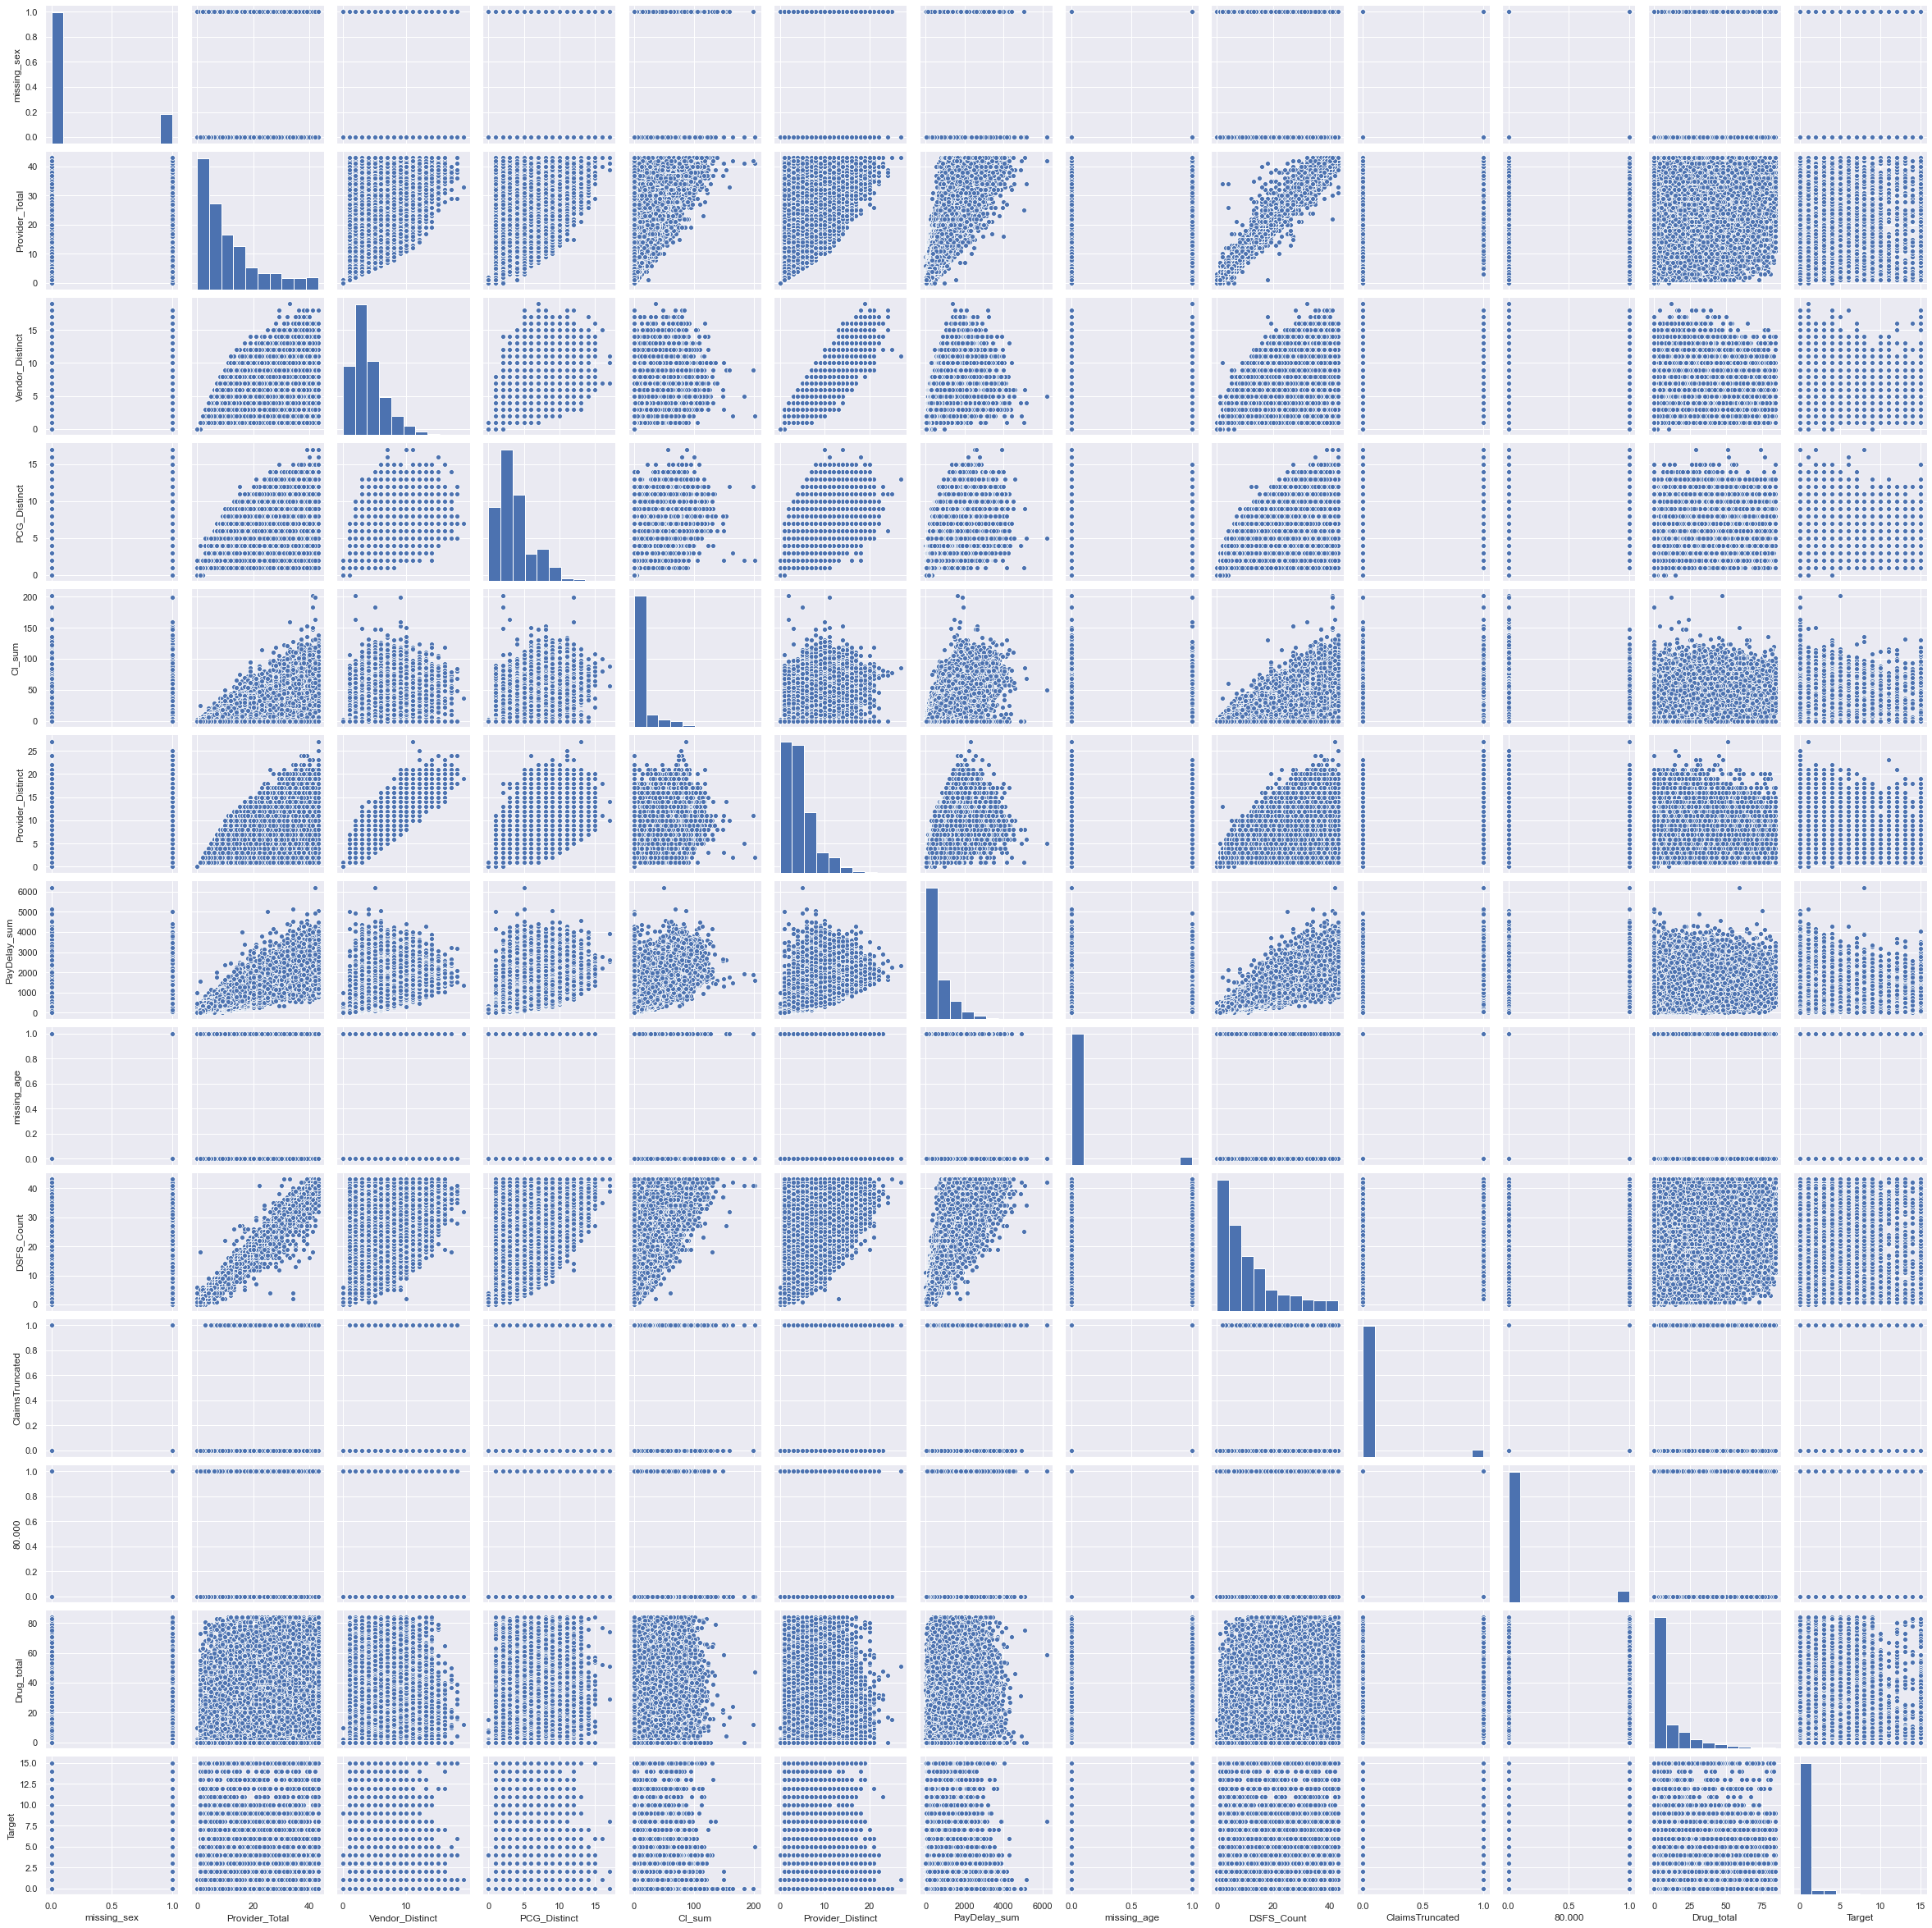

In [61]:
#Scatter plot của top 12 các variables và 'Target' có highest feature importances
# Có 1 số biến có linear correlation (vd: Provider_total (CLaims_distinct) với PayDelay, với DSFS)
# Các biến không có mối quan hệ với nhau theo linear sẽ k bị overlap lên nhau khi predict 
# Riêng với biến Target variable, các biến khác k có mối quan hệ linear regression. Do biến target chủ yếu đang là 0 nên k có tác động rõ rệt
sns.set()
cols = ['missing_sex','Provider_Total','Vendor_Distinct','PCG_Distinct','CI_sum','Provider_Distinct','PayDelay_sum','missing_age'
                        ,'DSFS_Count','ClaimsTruncated','80.000','Drug_total','Target']
sns.pairplot(fclaims_pastyr[cols], height = 2.5)
plt.show()

In [33]:
#Correlation giữa Specialty và Target
claims_Spec = fclaims_pastyr.groupby('Target').agg({
    'sp1_Int':'sum',
    'sp2_Lab':'sum',
    'sp3_Prac':'sum',
    'sp4_Sur':'sum',
    'sp5_DiIma':'sum',
    'sp8_Pedia':'sum',
    'sp13_null':'sum'}).reset_index()
claims_Spec_corr = claims_Spec.corr()
claims_Spec_corr

Target  sp1_Int  sp2_Lab  sp3_Prac  sp4_Sur  sp5_DiIma  sp8_Pedia  \
Target      1.000   -0.470   -0.470    -0.471   -0.471     -0.471     -0.472   
sp1_Int    -0.470    1.000    1.000     1.000    1.000      1.000      1.000   
sp2_Lab    -0.470    1.000    1.000     1.000    1.000      1.000      1.000   
sp3_Prac   -0.471    1.000    1.000     1.000    1.000      1.000      1.000   
sp4_Sur    -0.471    1.000    1.000     1.000    1.000      1.000      1.000   
sp5_DiIma  -0.471    1.000    1.000     1.000    1.000      1.000      1.000   
sp8_Pedia  -0.472    1.000    1.000     1.000    1.000      1.000      1.000   
sp13_null  -0.473    1.000    1.000     1.000    1.000      1.000      1.000   

           sp13_null  
Target        -0.473  
sp1_Int        1.000  
sp2_Lab        1.000  
sp3_Prac       1.000  
sp4_Sur        1.000  
sp5_DiIma      1.000  
sp8_Pedia      1.000  
sp13_null      1.000

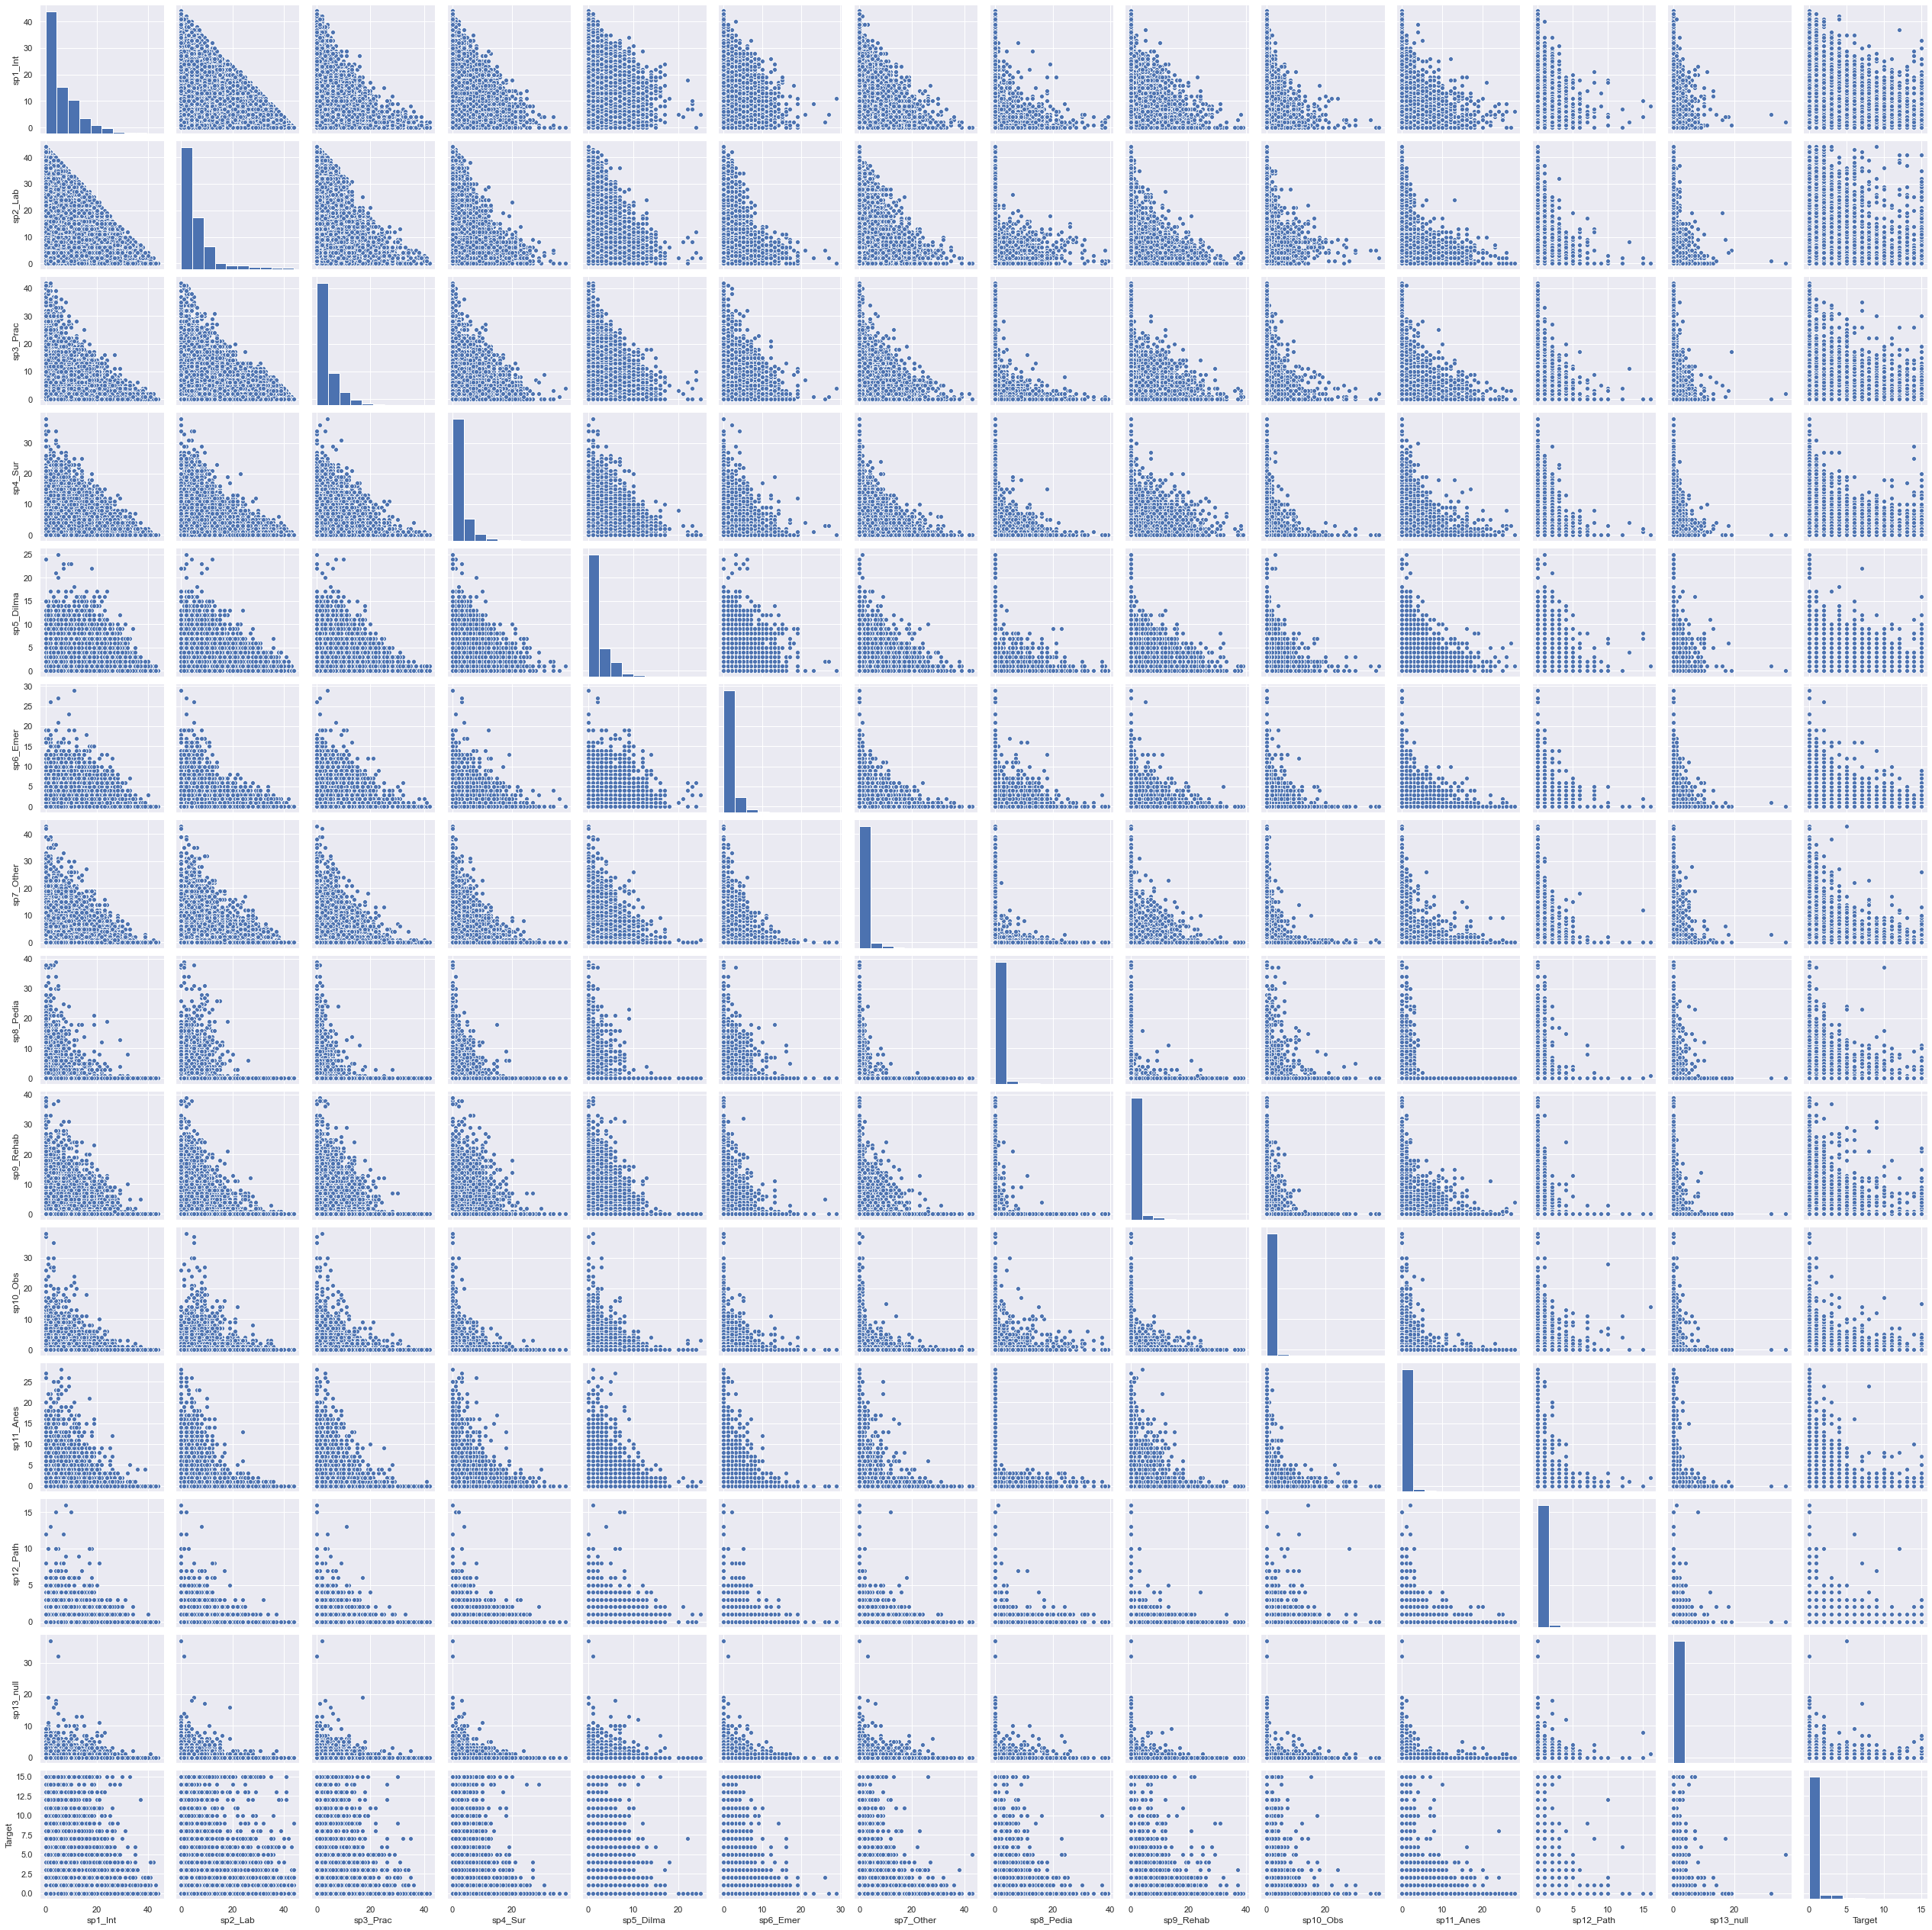

In [27]:
sns.set()
cols = ['sp1_Int','sp2_Lab','sp3_Prac','sp4_Sur','sp5_DiIma','sp6_Emer','sp7_Other','sp8_Pedia'
                        ,'sp9_Rehab','sp10_Obs','sp11_Anes','sp12_Path','sp13_null','Target']
sns.pairplot(fclaims_pastyr[cols], height = 2.5)
plt.show()


In [23]:
#Correlation giữa Condition và Target
claims_Spec = fclaims_pastyr.groupby('Target').agg({
    'pgc28_GYNECA':'sum',
    'pgc19_CANCRB':'sum',
    'pgc3_ARTHSPIN':'sum',
    'pgc23_HEMTOL':'sum',
    'pgc7_SKNAUT':'sum',
    'pgc1_MSC2a3':'sum',
    'pgc12_RENAL3':'sum'}).reset_index()    

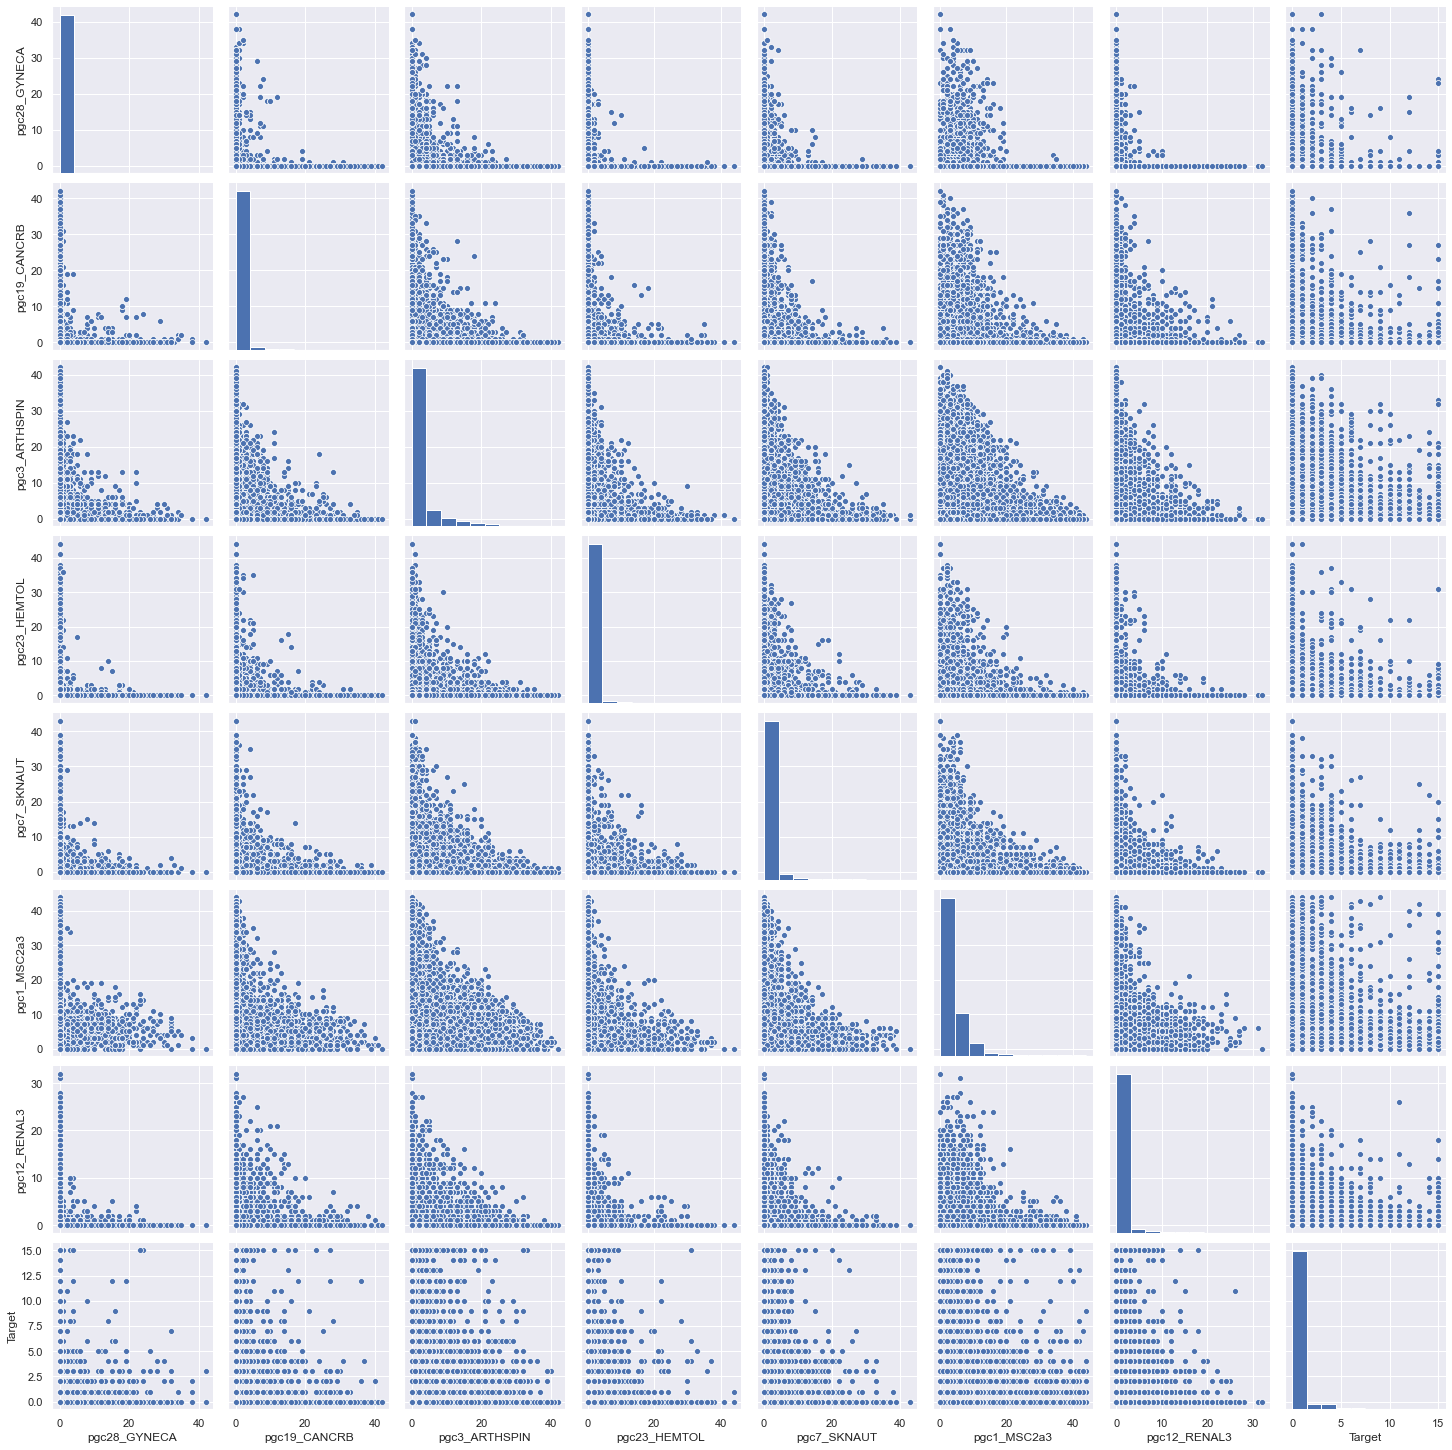

In [22]:
sns.set()
cols = ['pgc28_GYNECA','pgc19_CANCRB','pgc3_ARTHSPIN','pgc23_HEMTOL','pgc7_SKNAUT','pgc1_MSC2a3','pgc12_RENAL3','Target']
sns.pairplot(fclaims_pastyr[cols], height = 2.5)
plt.show()
